# Aspect-Based Sentiment Classification with BERT (SemEval-2014 Laptops Dataset)

## Step 1: Install Dependencies

In [1]:
!pip install transformers datasets scikit-learn pandas seaborn

## Step 2: Import Libraries

In [3]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## Step 3: Load and Preprocess Dataset

In [18]:
# Sample format expected:
# sentence,aspect,label (where label is 0=negative, 1=neutral, 2=positive)
df = pd.read_csv('/kaggle/input/semeval-2014-task-4-aspectbasedsentimentanalysis/Laptop_Train_v2.csv')  # Replace with your actual file
df['label'] = df['polarity'].map({'negative': 0, 'neutral': 1, 'positive': 2})
df = df.dropna(subset=['label'])  # Drop rows with unmapped polarity
df['label'] = df['label'].astype(int)  # Ensure proper dtype
df = df[['Sentence', 'Aspect Term', 'label']]

In [19]:
print(df['label'].isnull().sum())
print(df[df['label'].isnull()])

0
Empty DataFrame
Columns: [Sentence, Aspect Term, label]
Index: []


## Step 4: Tokenization and Dataset Creation

In [20]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class ABSADataset(Dataset):
    def __init__(self, df, tokenizer, max_len=128):
        self.sentences = df['Sentence'].tolist()
        self.aspects = df['Aspect Term'].tolist()
        self.labels = df['label'].tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        aspect = self.aspects[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text=sentence,
            text_pair=aspect,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.long)

        }

# Split dataset

In [21]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_dataset = ABSADataset(train_df, tokenizer)
test_dataset = ABSADataset(test_df, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

## Step 5: Model Initialization and Training

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Training loop

In [23]:
model.train()
for epoch in range(3):
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

Epoch 1, Loss: 96.2902
Epoch 2, Loss: 60.4799
Epoch 3, Loss: 42.4213


## Step 6: Evaluation and Visualization

              precision    recall  f1-score   support

    negative       0.86      0.76      0.80       181
     neutral       0.59      0.61      0.60       114
    positive       0.75      0.83      0.79       168

    accuracy                           0.75       463
   macro avg       0.73      0.73      0.73       463
weighted avg       0.75      0.75      0.75       463



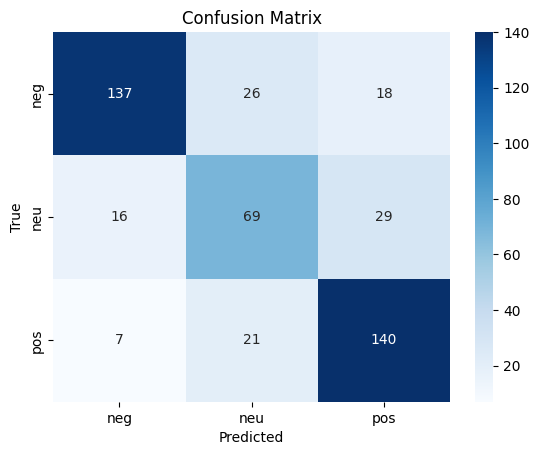

In [24]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=['negative', 'neutral', 'positive']))

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['neg','neu','pos'], yticklabels=['neg','neu','pos'], cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [25]:
def predict_absa_sentiment(model, tokenizer, sentence, aspect):
    model.eval()
    encoding = tokenizer(sentence, aspect, return_tensors='pt', padding=True, truncation=True, max_length=128)
    input_ids = encoding['input_ids'].to(model.device)
    attention_mask = encoding['attention_mask'].to(model.device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        pred = torch.argmax(logits, dim=1).item()

    return {0: "negative", 1: "neutral", 2: "positive"}[pred]


In [31]:
# Raw example
sentence = "the pizza are so good but the service is terrible"
aspect = ['pizza', 'service']

predict_absa_sentiment(model, tokenizer, sentence, aspect)

'positive'